# MARKETING Y COMUNICACIÓN
ANÁLISIS DE NEGOCIO

# SPRINT N°2
* Fecha de inicio: 02/12/2024
* Fecha de presentación: 9/12/2024

**OBJETIVOS**
1) ¿Cuál es el impacto del tipo de contacto, ya sea móvil o telefónico, a la tasa de conversión de nuestras campañas de marketing?
2) ¿Cómo podemos ajustar nuestras estrategias de comunicación en función de estos resultados?

## LIBRERIAS

In [2]:
import pymysql
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## DATAFRAME: df_BANK_marketing

In [3]:
df_BANK_marketing = pd.read_parquet('df_BANK_marketing_Sprint2.parquet')
df_BANK_marketing.info()
#16.163 registros

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16163 entries, 0 to 16162
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   16163 non-null  int64  
 1   age                  16163 non-null  float64
 2   job                  16163 non-null  object 
 3   marital              16163 non-null  object 
 4   education            16163 non-null  object 
 5   is_in_default        16163 non-null  int64  
 6   balance              16163 non-null  int64  
 7   housing              16163 non-null  int32  
 8   loan                 16163 non-null  int64  
 9   contact              16163 non-null  object 
 10  day                  16163 non-null  int64  
 11  month                16163 non-null  object 
 12  duration             16163 non-null  int64  
 13  campaign             16163 non-null  int64  
 14  pdays                16163 non-null  int64  
 15  previous             16163 non-null 

## TASA DE CONVERSIÓN SEGÚN 'contact'

Para comenzar con el análisis, averiguaré el valor de la tasa de conversión según el tipo de contacto:
* 'cellular'
* 'telephone'

### FILTRO 'unknown' DE 'contact'

In [4]:
df_BANK_marketing = df_BANK_marketing[df_BANK_marketing['contact'] != 'unknown']
df_BANK_marketing.info()
#12.779 registros -> 3.384 registros en el camino. Representan un 20.94% de la población

<class 'pandas.core.frame.DataFrame'>
Index: 12779 entries, 368 to 16162
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   12779 non-null  int64  
 1   age                  12779 non-null  float64
 2   job                  12779 non-null  object 
 3   marital              12779 non-null  object 
 4   education            12779 non-null  object 
 5   is_in_default        12779 non-null  int64  
 6   balance              12779 non-null  int64  
 7   housing              12779 non-null  int32  
 8   loan                 12779 non-null  int64  
 9   contact              12779 non-null  object 
 10  day                  12779 non-null  int64  
 11  month                12779 non-null  object 
 12  duration             12779 non-null  int64  
 13  campaign             12779 non-null  int64  
 14  pdays                12779 non-null  int64  
 15  previous             12779 non-null  in

### TASA DE ÉXITO SEGÚN EL TIPO DE CONTACTO

In [5]:
#'deposit' == 1 (Contrató depósito) - success
success_contacts = df_BANK_marketing[df_BANK_marketing['deposit'] == 1]

#'deposit' == 0 (No contrató depósito) - unsuccess
unsuccess_contacts = df_BANK_marketing[df_BANK_marketing['deposit'] == 0]

#Count total de clientes contactados
total_count = df_BANK_marketing.groupby('contact')['deposit'].count()

#Count de success 
success_count = success_contacts.groupby('contact')['deposit'].count()

#Count de unsuccess 
unsuccess_count = unsuccess_contacts.groupby('contact')['deposit'].count()

#df con el total de contactos, success y unsuccess
contact_analysis = pd.DataFrame({
    'Total contactados': total_count,
    'Contactos exitosos': success_count,
    'Contactos no exitosos': unsuccess_count
})

#Tasa de éxito: success / total de contactos
contact_analysis['Tasa de éxito (%)'] = round((contact_analysis['Contactos exitosos'] / contact_analysis['Total contactados']) * 100,1)

#Tasa de no éxito: unsuccess / total de contactos
contact_analysis['Tasa de no éxito (%)'] = round((contact_analysis['Contactos no exitosos'] / contact_analysis['Total contactados']) * 100,1)

contact_analysis


,Total contactados,Contactos exitosos,Contactos no exitosos,Tasa de éxito (%),Tasa de no éxito (%)
contact,,,,,
cellular,11672,6341,5331,54.3,45.7
telephone,1107,549,558,49.6,50.4


* En la siguiente tabla resumen se observa como la tasa de conversión cuando el cliente fue contactado por **movil** fue del **54.3%**.
* Mientras que la tasa de conversión al ser contactado por **teléfono** deciende al **49.6%**.

Esto muestra que contactar a través de celulares es más efectivo, con una diferencia de **4.8** puntos porcentuales en la tasa de éxito

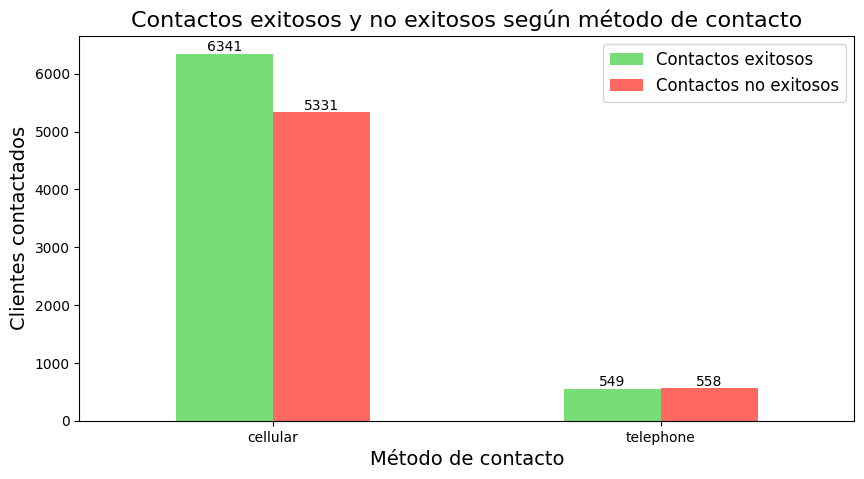

In [6]:
ax = contact_analysis[['Contactos exitosos', 'Contactos no exitosos']].plot(
    kind='bar', 
    stacked=False, 
    figsize=(10, 5),
    color=['#77dd77', '#ff6961']  #Colores verde (Contactos Exitosos) y rojo (Contactos No exitosos)
)

plt.title('Contactos exitosos y no exitosos según método de contacto', fontsize=16)
plt.xlabel('Método de contacto', fontsize=14)
plt.ylabel('Clientes contactados', fontsize=14)
plt.xticks(rotation=0)
plt.legend(fontsize=12)

#Valores sobre barra
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  #Centrado en la barra
            height,  #Encima de la barra
            f'{int(height)}',  #Valor a mostrar
            ha='center', 
            va='bottom', 
            fontsize=10
        )

plt.show()

¿Es este 4.8 % significativo o producto del azar? 

Para ello voy a ejectuar un **Chi-Squared Test** con las siguientes hipótesis:

* **H0:** Las variables 'contact' y 'deposit' son independientes
* **H1:** Hay una dependencia entre las dos variables

In [27]:
from scipy.stats import chi2_contingency

#Tabla de contingencia entre las dos variables a analizar
contingency_table = pd.crosstab(df_BANK_marketing['contact'], df_BANK_marketing['deposit'])

#Test Chi-cuadrado
stat, p, dof, expected = chi2_contingency(contingency_table)

#chi2_contingency:
#stat: El estadístico Chi-cuadrado calculado.
#p: El valor p asociado con la prueba.
#dof: Los grados de libertad.
#expected: La tabla de frecuencias esperadas si las variables fueran independientes.

#Resultados
print('Chi-Squared stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Las variables contact y deposit son independientes ❌')
else:
    print('Hay una dependencia entre las variables contact y deposit ✅')

Chi-Squared stat=8.927, p=0.003
Hay una dependencia entre las variables contact y deposit ✅


El resultado del valor p (p=0.003) indica que es **altamente improbable** que la relación observada entre las variables _contact_ y _deposit_ **sea producto del azar**. 
Esto se debe a que el valor p es mucho menor que el umbral típico de significancia (0.05), por lo que **rechazamos la hipótesis nula de independencia**.

## AJUSTE DE ESTRATEGIAS DE COMUNICACIÓN

### VARIABLES POTENCIALES

In [42]:
#Resumen estadístico por grupo ('age' y 'balance')
summary = df_BANK_marketing.groupby(['contact', 'deposit'])[['age', 'balance']].describe().round(1)
summary

age                                           balance  \
                    count  mean   std   min   25%   50%   75%   max   count   
contact   deposit                                                             
cellular  0        5331.0  40.3  10.0  18.0  32.0  38.0  47.0  83.0  5331.0   
          1        6341.0  40.9  12.9  18.0  31.0  37.0  49.0  93.0  6341.0   
telephone 0         558.0  46.7  14.2  19.0  36.0  46.0  55.0  89.0   558.0   
          1         549.0  54.2  17.8  19.0  39.0  54.0  69.0  95.0   549.0   

                                                                           
                     mean     std     min    25%     50%     75%      max  
contact   deposit                                                          
cellular  0        1267.2  3120.3 -6847.0   55.0   398.0  1273.0  66653.0  
          1        1766.5  3180.7 -3058.0  213.0   718.0  2104.0  52587.0  
telephone 0        1616.1  3266.8 -1965.0  154.0   644.0  1795.0  31868.0  
          1        3086.6  7657.9  -277.0  426.0  1443.0  3376.0  81204.0

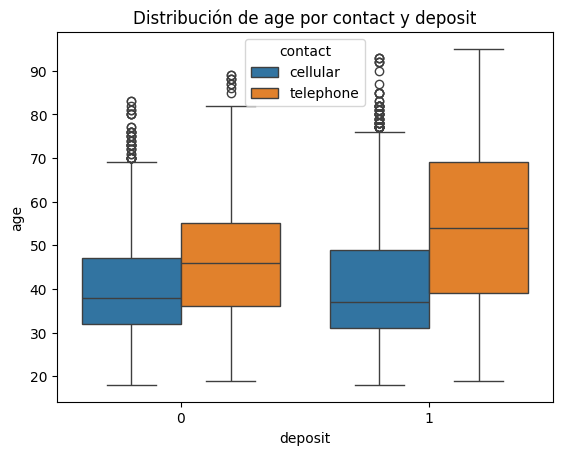

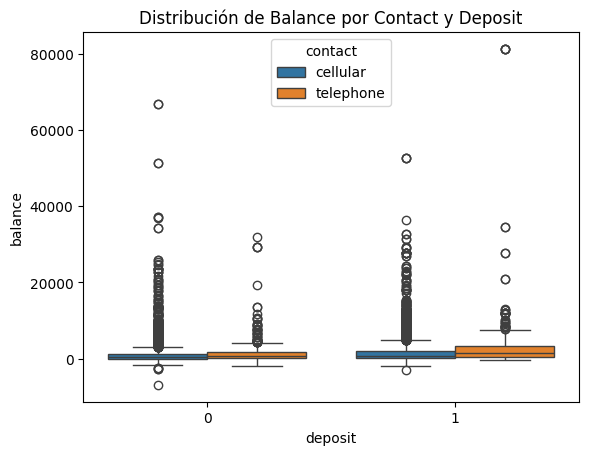

In [63]:
#Visualización de age
sns.boxplot(data=df_BANK_marketing, x='deposit', y='age', hue='contact')
plt.title('Distribución de age por contact y deposit')
plt.show()

#Visualización de balance
sns.boxplot(data=df_BANK_marketing, x='deposit', y='balance', hue='contact')
plt.title('Distribución de Balance por Contact y Deposit')
plt.show()

In [62]:
from scipy.stats import ttest_ind

# Prueba t para Age
age_yes = df_BANK_marketing[df_BANK_marketing['deposit'] == 1]['age']
age_no = df_BANK_marketing[df_BANK_marketing['deposit'] == 0]['age']
stat, p = ttest_ind(age_yes, age_no)
print(f"Prueba t para Age: stat={stat:.3f}, p={p:}")

# Prueba t para Balance
balance_yes = df_BANK_marketing[df_BANK_marketing['deposit'] == 1]['balance']
balance_no = df_BANK_marketing[df_BANK_marketing['deposit'] == 0]['balance']
stat, p = ttest_ind(balance_yes, balance_no)
print(f"Prueba t para Balance: stat={stat:.3f}, p={p:}")

Prueba t para Age: stat=4.726, p=2.312822418507303e-06
Prueba t para Balance: stat=9.243, p=2.775239765299011e-20


## CONCLUSIÓN

1) ¿Cuál es el impacto del tipo de contacto, ya sea móvil o telefónico, a la tasa de conversión de nuestras campañas de marketing?

* El Móvil impactó en un 4,8 % más la tasa de conversión ✅ 

2) ¿Cómo podemos ajustar nuestras estrategias de comunicación en función de estos resultados?

* Cuándo el cliente tiene entre 31 y 37 años: La comunicación debe ser por móvil
* Cuándo el cliente tiene entre 54 y 69 años: La comunicación debe ser por teléfono

